In [1]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import  preprocessing
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import scipy as sc
import pandas as pd
import random
from PIL import Image

In [207]:
DATASET_PATH = 'Datasets/BrainTumorImage/'
DATA_DF_PATH = DATASET_PATH + "data_df.csv"
IMAGE_DF_PATH = DATASET_PATH + "image_df.csv"
IMAGE_SIDE = 128
TOTAL_INPUTS = IMAGE_SIDE * IMAGE_SIDE
seed = 122
np.random.seed(seed)
random.seed(seed)

In [3]:
data_df = pd.read_csv(DATA_DF_PATH)
image_df = pd.read_csv(IMAGE_DF_PATH)

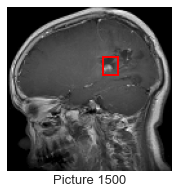

In [116]:
fig = plt.figure(figsize=[10, 10])
fig.patch.set_facecolor('white')


plt.subplot(2, 3, 1)
rand_pick = 1500

img = np.array(image_df.iloc[rand_pick]).reshape((128, 128))

data = data_df.iloc[rand_pick]
corner_x  = data["corner_x"]
corner_y  = data["corner_y"]
width  = data["width"]
height  = data["height"]

plt.imshow(img, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel('Picture ' + str(rand_pick), fontsize=13)
currentAxis = plt.gca()

currentAxis.add_patch(Rectangle((corner_x, corner_y), width, height, linewidth=2, edgecolor='r', facecolor='none'))

fig.subplots_adjust(hspace=-0.4)
plt.show()

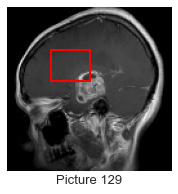

In [117]:
fig = plt.figure(figsize=[10, 10])
fig.patch.set_facecolor('white')


plt.subplot(2, 3, 1)
rand_pick = 129

img = np.array(image_df.iloc[rand_pick]).reshape((128, 128))
#im = Image.fromarray(np.uint8(img))
#new = im.resize((32,32))
#img2=np.asarray(new)

data = data_df.iloc[rand_pick]
corner_x  = data["corner_x"]/1.5
corner_y  = data["corner_y"]/1.5
width  = data["width"]
height  = data["height"]

plt.imshow(img, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel('Picture ' + str(rand_pick), fontsize=13)
currentAxis = plt.gca()

currentAxis.add_patch(Rectangle((corner_x, corner_y), width, height, linewidth=2, edgecolor='r', facecolor='none'))

fig.subplots_adjust(hspace=-0.4)
plt.show()

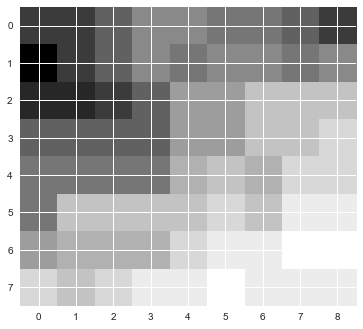

In [118]:
tumor_ = img[corner_x.astype(int):(corner_x.astype(int)+8), corner_y.astype(int):(corner_x.astype(int)+8)]
plt.imshow(tumor_, cmap='gray')

In [260]:
pick = [129, 130, 1350, 12, 171, 455, 1567]
pick2 = [688, 588, 290, 467, 740, 866, 1183]

tumor_list1 = np.empty(shape=[0,4])
benign_list = np.empty(shape=[0,4])

for i in range (7):
    

    img = np.array(image_df.iloc[pick[i]]).reshape((128, 128))

    data = data_df.iloc[rand_pick]
    corner_x  = data["corner_x"]
    corner_y  = data["corner_y"]
    width  = data["width"]
    height  = data["height"]

    tumor_ = img[corner_x.astype(int):(corner_x.astype(int)+4), corner_y.astype(int):(corner_x.astype(int)+4)]
    tumor_Im = Image.fromarray(np.uint8(tumor_))
    tumor_res = tumor_Im.resize((4,1))
    tumor_fin = np.asarray(tumor_res)
    
    tumor_list1 = np.append(tumor_list1, tumor_fin, axis=0)
    

In [261]:
tumor_list2 = np.empty(shape=[0,4])


for i in range (7):
    

    img = np.array(image_df.iloc[pick2[i]]).reshape((128, 128))

    data = data_df.iloc[rand_pick]
    corner_x  = data["corner_x"]
    corner_y  = data["corner_y"]
    width  = data["width"]
    height  = data["height"]

    tumor_ = img[corner_x.astype(int):(corner_x.astype(int)+4), corner_y.astype(int):(corner_x.astype(int)+4)]
    tumor_Im = Image.fromarray(np.uint8(tumor_))
    tumor_res = tumor_Im.resize((4,1))
    tumor_fin = np.asarray(tumor_res)
    
    tumor_list2 = np.append(tumor_list2, tumor_fin, axis=0)

In [262]:
b_list = np.append(pick, pick2)

for i in range (14):
    

    img = np.array(image_df.iloc[b_list[i]]).reshape((128, 128))

    data = data_df.iloc[rand_pick]
    corner_x  = data["corner_x"]/1.5
    corner_y  = data["corner_y"]/1.5
    width  = data["width"]
    height  = data["height"]

    
    benign_ = img[corner_x.astype(int):(corner_x.astype(int)+4), corner_y.astype(int):(corner_x.astype(int)+4)]
    benign_Im = Image.fromarray(np.uint8(benign_))
    benign_res = benign_Im.resize((4,1))
    benign_fin = np.asarray(benign_res)
    
    benign_list = np.append(benign_list, benign_fin, axis=0)

In [263]:
params = np.random.random(24, requires_grad=True)

x_tumors1 = preprocessing.normalize(tumor_list1, axis=0)
x_tumors2 = preprocessing.normalize(tumor_list2, axis=0)
x_benign = preprocessing.normalize(benign_list, axis=0)

In [264]:
def state_prep(data1, data2):   # Embeds desired classical information to the quantum circuit
    qml.BasisEmbedding(np.array([0, 0, 0, 0]), wires=[0, 1, 2, 3])
    
    for i in range (4):
        qml.RY(data1[i], wires=i+4)

    for j in range (4):
        qml.RY(data2[j], wires=j+8)

In [265]:
# Lets build a circuit, This is where the magic happens.

dev_p = qml.device('default.qubit', wires=12, shots=None)    # Define the quantum device

@qml.qnode(dev_p)
def circuit(params, data1, data2):
    n_qubits = 12
    w_count = 4
    n = 0
    
    state_prep(data1, data2)
 
    while w_count < 12:                                       
        qml.Rot(params[n], params[n+1], params[n+2], wires=w_count)
        w_count += 1
        n += 3
            
    qml.CNOT(wires=[4, 5])
    qml.CNOT(wires=[5, 6])
    qml.CNOT(wires=[6, 7])
    qml.CNOT(wires=[7, 4])

    qml.CNOT(wires=[8, 9])
    qml.CNOT(wires=[9, 10])
    qml.CNOT(wires=[10, 11])
    qml.CNOT(wires=[11, 8])



    

    qml.Hadamard(0)             # Ancilla qubit 1
    qml.CSWAP(wires=(0, 4, 2))
    qml.Hadamard(0)
    
    qml.Hadamard(1)             # Ancilla qubit 2
    qml.CSWAP(wires=(1, 8, 3))
    qml.Hadamard(1)


    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))

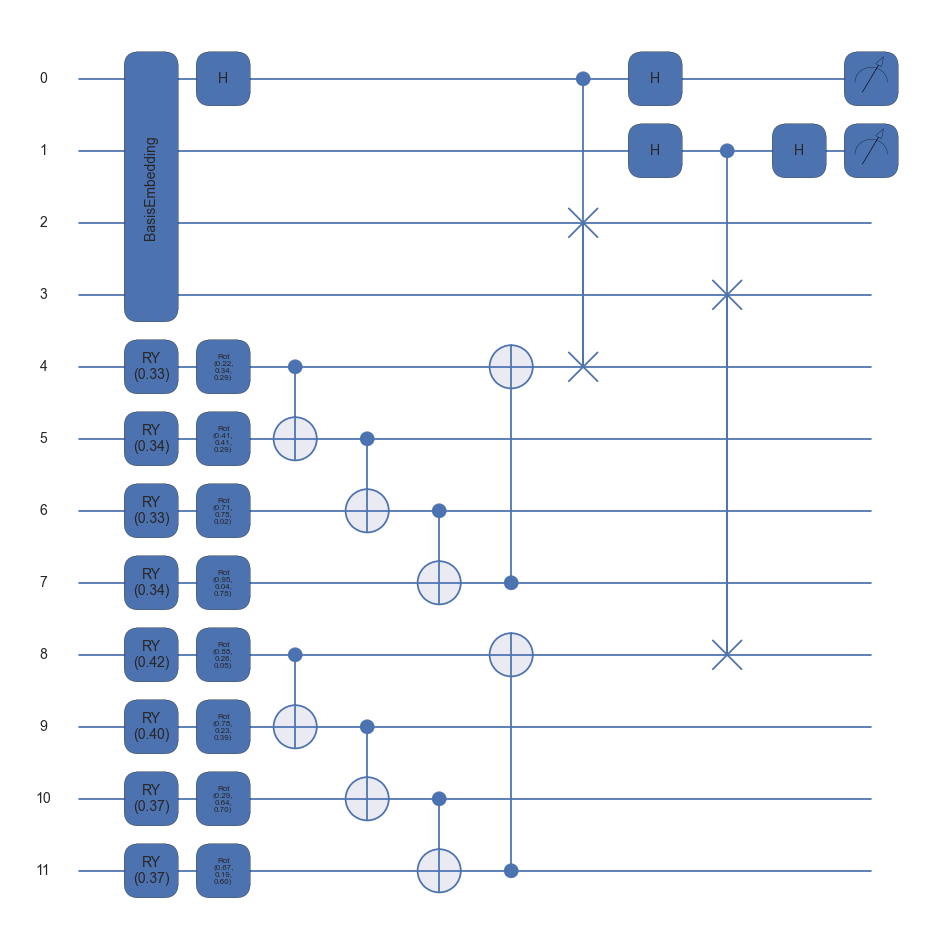

In [266]:
ancilla = circuit(params, x_tumors1[0], x_tumors2[1])
fig, ax = qml.draw_mpl(circuit, show_all_wires=True, decimals=2)(params, x_tumors1[0], x_tumors2[1])

In [267]:
def anci_dist(x, data1, data2, i):
    anci_0, anci_1 = circuit(x, data1[i], data2[i])
    return anci_0, anci_1

In [291]:
def fn_cost(x, data1, data2, i):      # Cost calculation is simple, in perfect match we want: expval(anci) = 0
    funx = 0
    funx2 = 0
    steps = 0
    anci_0, anci_1 = anci_dist(x, data1, data2, i)
    funx += anci_0 
    funx2 += anci_1
    cost_hist.append(funx)
    steps += 1
    print(funx, funx2)
    return funx, funx2

In [295]:
cost_hist = []
cost1_hist = []
weight_tensor = []


for i in range(6):
    minimizer = {'method':'COBYLA', 'args':(x_tumors1, x_tumors2, i)}             # COBYLA was chosen for reduced cpu time. Results are more than satisfactory
    opti = sc.optimize.basinhopping(fn_cost, params, minimizer_kwargs=minimizer, niter=0)
    weight_tensor.append(opti.x)

0.6826542689440585 0.760118492290609
0.6826542689440582 0.760118492290609
0.6826542689440587 0.7601184922906092
0.6826542689440586 0.7601184922906091
0.7074625231022736 0.7601184922906098
0.4627857300128565 0.7601184922906091
0.4627857300128564 0.7601184922906088
0.448769422088102 0.7601184922906092
0.5086309070468457 0.7601184922906091
0.448769422088102 0.7601184922906092
0.4480536364093303 0.7601184922906095
0.46810317526535944 0.7601184922906093
0.44805363640932994 0.760118492290609
0.44805363640933016 0.7601184922906092
0.4480536364093303 0.7601184922906095
0.44805363640933016 0.7601184922906092
0.44805363640932994 0.7759321974169133
0.44805363640933005 0.5424763523127494
0.44805363640933 0.760118492290609
0.44805363640933005 0.8006131281195227
0.44805363640933005 0.3768466551153187
0.44805363640933005 0.7601184922906089
0.44805363640933016 0.772508537391343
0.4480536364093298 0.5486414810854046
0.44805363640932994 0.5486414810854048
0.1367580662405799 0.5486414810854048
0.10866101

Text(0.5, 0, '# of Steps')

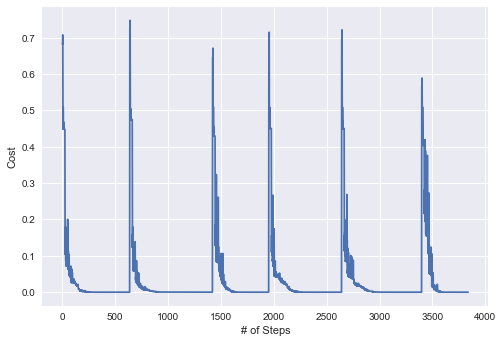

In [296]:
plt.style.use("seaborn")
plt.plot(cost_hist)
plt.ylabel("Cost")
plt.xlabel("# of Steps")

In [303]:
opt_error = []
for i in range (7):
    #for j in range (len(x_benign)):
    ancilla1, ancilla2 = circuit(weight_tensor[0], x_tumors1[i], x_benign[i])
    total1 = ancilla2
    opt_error.append(total1)
opt_error

[tensor(0.30543002, requires_grad=True),
 tensor(0.30778686, requires_grad=True),
 tensor(0.33235828, requires_grad=True),
 tensor(0.32749685, requires_grad=True),
 tensor(0.31391797, requires_grad=True),
 tensor(0.31243757, requires_grad=True),
 tensor(0.31214869, requires_grad=True)]

In [304]:
opt_error_sim = []
for i in range (7):
    #for j in range (len(x_tumors2)):
    ancilla1, ancilla2 = circuit(weight_tensor[0], x_tumors1[i], x_tumors2[i])
    total =  ancilla1
    opt_error_sim.append(total)
opt_error_sim

[tensor(7.41590567e-10, requires_grad=True),
 tensor(0.00578929, requires_grad=True),
 tensor(0.00375486, requires_grad=True),
 tensor(0.00033889, requires_grad=True),
 tensor(0.00094197, requires_grad=True),
 tensor(0.05465241, requires_grad=True),
 tensor(0.00027406, requires_grad=True)]

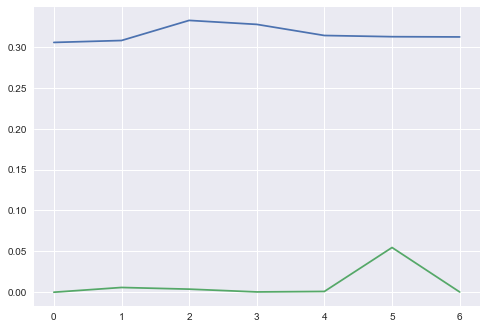

In [305]:
def plot1(ax):

    return ax.plot(opt_error)

def plot2(ax):

    return ax.plot(opt_error_sim)


fig, ax = plt.subplots(1,1)
l1 = plot1(ax)
l2 = plot2(ax)
plt.show()

In [306]:
error = []
for i in range (7):
    #for j in range (len(x_benign)):
    ancilla1, ancilla2 = circuit(params, x_tumors1[i], x_benign[i])
    total2 = ancilla2
    error.append(total2)
error


[tensor(0.78862476, requires_grad=True),
 tensor(0.78223413, requires_grad=True),
 tensor(0.72545645, requires_grad=True),
 tensor(0.74062583, requires_grad=True),
 tensor(0.77018288, requires_grad=True),
 tensor(0.78749123, requires_grad=True),
 tensor(0.76804194, requires_grad=True)]

In [307]:
error_sim = []
for i in range (7):
    #for j in range (len(x_benign)):
    ancilla1, ancilla2 = circuit(params, x_tumors1[i], x_tumors2[i])
    total3 = ancilla1
    error_sim.append(total3)
error_sim

[tensor(0.68265427, requires_grad=True),
 tensor(0.72615756, requires_grad=True),
 tensor(0.64584976, requires_grad=True),
 tensor(0.68990453, requires_grad=True),
 tensor(0.69574631, requires_grad=True),
 tensor(0.56866425, requires_grad=True),
 tensor(0.69080593, requires_grad=True)]

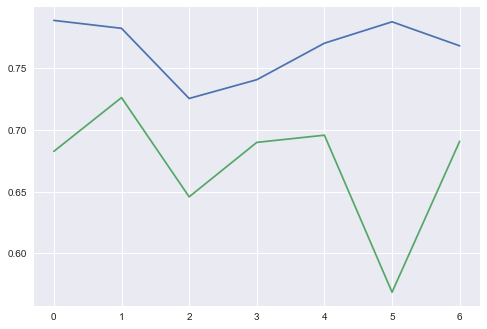

In [308]:
def plot3(ax):

    return ax.plot(error)

def plot4(ax):

    return ax.plot(error_sim)


fig, ax = plt.subplots(1,1)
l1 = plot3(ax)
l2 = plot4(ax)
plt.show()